[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


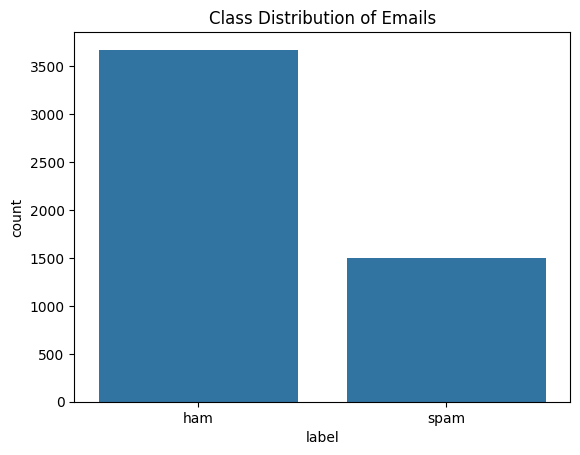

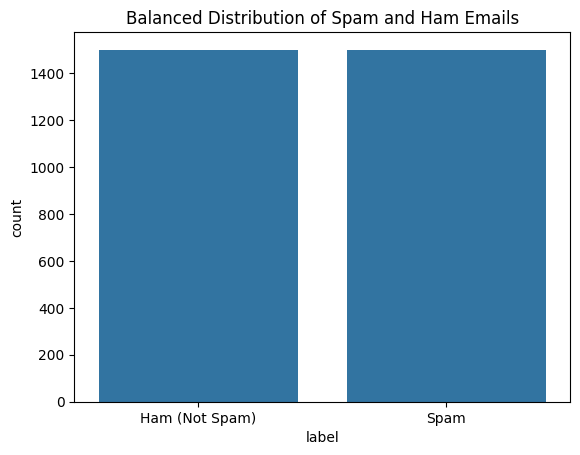

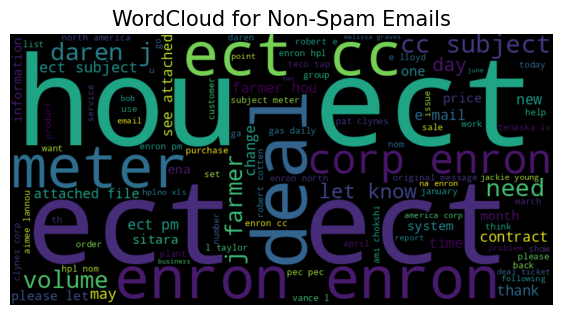

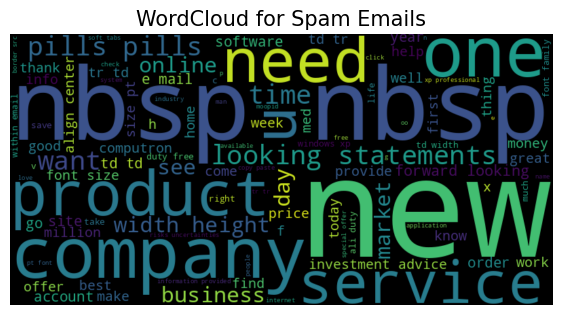

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5436 - loss: 0.6714 - val_accuracy: 0.9267 - val_loss: 0.2763 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9221 - loss: 0.2586 - val_accuracy: 0.9583 - val_loss: 0.1736 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9611 - loss: 0.1623 - val_accuracy: 0.9617 - val_loss: 0.1585 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9635 - loss: 0.1423 - val_accuracy: 0.9667 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9673 - loss: 0.1345 - val_accuracy: 0.9650 - val_loss: 0.1558 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9731 - loss: 0.1151 - val_accuracy: 0.9717 - val_loss: 0.1190 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9788 - loss: 0.0925 - val_acc

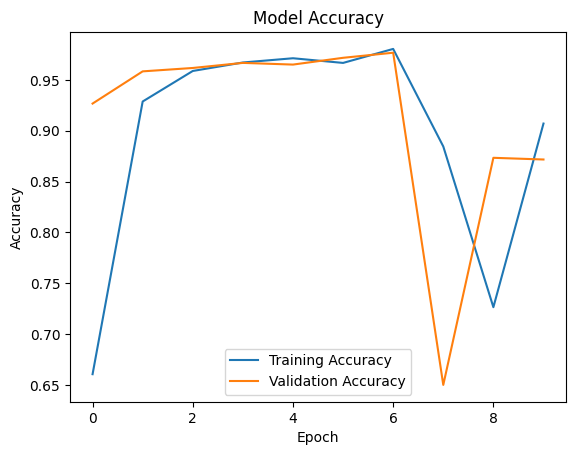

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('spam_ham_dataset.csv')
data.head()
data.shape
sns.countplot(x='label', data=data)
plt.title("Class Distribution of Emails")
plt.show()

ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# Downsample Ham emails to match the number of Spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

# Clean the text
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

# Helper function to remove the stop words.
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)
    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

# Tokenization and Padding
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

model.summary()
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es])

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()